In [33]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

data = pd.read_excel("Analysis_Data.xlsx",sheet_name="Drilling Cost",skiprows = 2)

oil = pd.read_excel("Analysis_Data.xlsx",sheet_name="Price Projections",skiprows = 2)
oil.columns = ["Year","High","Low","Expected"]
oil = oil[0:15]

data.columns = ["Date","Oil","Gas","Dry","OilChange","GasChange",'DryChange']
data['Drill'] = (data['Oil'] + data['Dry'] + data['Gas']) / 3
data['DrillChange'] = data['Drill'].pct_change()

data['Year'] = data['Date'].dt.year

# Drop 2007
data = data[data["Year"] != 2007]

data.head(10)

normal = data[(data['Year'] > 1990)]

kernelData = list(normal['OilChange']) + list(normal['GasChange']) + list(normal['DryChange'])

loc = pd.Series(kernelData).mean()
scale = np.sqrt(pd.Series(kernelData).var())

### Drill Costs

In [34]:
def drill(k = False):
    changes = []
    
    ## 2007-2012 Depending on k = 
    if k == True:
        samp = list(kernel.resample(size = 6).flatten());
    else:
        samp = list(np.random.normal(loc = loc,scale = scale,size = 6))
    changes += (samp)
    ## 2012 - 2015
    samp = list(np.random.triangular(right = -.07,mode = -.0917,left = -.22,size = 3))
    changes += samp
    ## 2015-2025
    samp = list(np.random.triangular(left = .02,mode = .05,right = .06,size = 10))
    changes += samp
    
    # Create the product of all the years changes 
    temp = pd.Series([1] * len(changes))
    changes = pd.Series(changes) + temp
    
    changes = changes.prod().astype(float)
    
    changes = changes * 2279.7999999999997 * 1000
    return changes  


### Initial Costs

In [35]:
def initial(n = 10, dry = False):
    # Acreage
    acres = pd.Series(np.random.normal(loc = 600, scale = 50,size = n))
    acres = acres * 960
    
    # Seismic 
    seismic = pd.Series(np.random.normal(loc = 3, scale = .35, size = n))
    seismic = seismic * 43000
    
    # Completion if dry 
    if dry != False:
        completion = [0] * n
    else: 
        completion = pd.Series(np.random.normal(loc = 390000,scale = 50000,size = n))
    
    # salary 
    #salary = pd.Series(np.random.triangular(left = 172000,mode = 215000, right = 279500,size = n))
    
    # Drilling
    drills = []
    for i in range(n):
        drills.append(drill())
    drills = pd.Series(drills)
    
    cost = acres + seismic + completion + drills

    return(cost)

### Production function
Helper function that produces a matrix of initial production and decline rates that are correlated,
with n columns

In [36]:
def production(n = 10,corr = .64):
    R = np.array([[1, corr], [corr, 1]])
    U = sp.linalg.cholesky(R, lower = False)

    def standardize(x):
        x_std = (x - np.mean(x))/np.std(x)
        return(x_std)

    def destandardize(x_std, x):
        x_old = (x_std * np.std(x)) + np.mean(x)
        return(x_old)
    
    ip = np.random.lognormal(mean = 6, sigma = .28,size = n)
    decline = np.random.uniform(low = .15, high = .32,size = n)
    
    combined = np.array([standardize(ip), standardize(decline)])
    corrComb = U @ combined
    
    final = np.array([destandardize(corrComb[0], ip), destandardize(corrComb[1], decline)])
    
    return final


### Oil Barrel Function
Produces 15 x n matrix of oil barrels numbers year by year

In [37]:
def oilBarrel(n = 10):
    vals = production(n = n)
    barrelMat = []
    for i in range(n):
        rate = vals[0,i]
        
        rateInit = vals[0,i]
        decline = vals[1,i]
        
        barrels = []
        for j in range(15):
            rateEnd = (1 - decline) * rate
            barrel = 365 * ((rate + rateEnd) / 2)
            rate = rateEnd
            barrels.append(barrel)
        barrelMat.append(barrels)
    
    barrelMat = pd.DataFrame(barrelMat).T
    return(barrelMat)

### Oil Price
Produces 15 x n matrix of oil prices

In [38]:
def oilPrice(n = 10):
    priceMat = []
    for j in range(n):
        
        prices = []
        for i in range(0,len(oil)):
            price = np.random.triangular(left = oil["Low"][i],mode = oil["Expected"][i], right = oil["High"][i])
            prices.append(price)
        priceMat.append(prices)
    
    priceMat = pd.DataFrame(priceMat).T
    return(priceMat)


        

### Oil Production Costs
Produces 15 x n matrix of costs per oil barrel

In [39]:
def oilProduction(n = 10):
    productionsMat = []
    for i in range(n):
        productions = list(np.random.normal(loc = 2.25,scale = .3,size = 15))
        productionsMat.append(productions)
    productionsMat = pd.DataFrame(productionsMat).T
    return(productionsMat)
        

### Revenue Function
Finds the total revenue after NRI, Barrel Productions, then taxes

In [40]:
def revenue(n= 10):
    barrels = oilBarrel(n = n)
    productions = oilProduction(n = n)
    prices = oilPrice(n = n)
    revenueMat = (barrels * prices)
    
    NRI = np.random.normal(loc = .75,scale = .02)
    
    revenueMat = revenueMat * NRI
    
    tax = .046
    
    revenueMat = revenueMat * (1 - tax)
    
    revenueMat = revenueMat - (barrels * productions)    

    return(revenueMat)
    

### FNR Function
Performs the right side of the NPV calculation

In [ ]:
def fnr(n = 10):
    revenueMat = revenue(n = n)
    wacc = 1.1
    total = []
    for j in range(0,len(revenueMat.columns)):
        temp = []
        for i in range(0,len(revenueMat)):
            rev = revenueMat.loc[i,j] / (wacc ** (i + 1))
            temp.append(rev)
        temp = pd.Series(temp)
        total.append(temp.sum())
    return(total)

### NPV Function
Adds initial costs to the FNR calculation

In [42]:
def npv(n = 10):
    
    salaries = np.random.triangular(left = 172000,mode = 215000, right = 279500,size = 1) * 16
    initials = initial(n = n)
    costs = salaries + initials
    profit = fnr(n = n)
    
    total = profit - costs
    return(total)
    

In [43]:
sims = npv(100000)

Mean Profit for Wet Well: 21766990.7180575


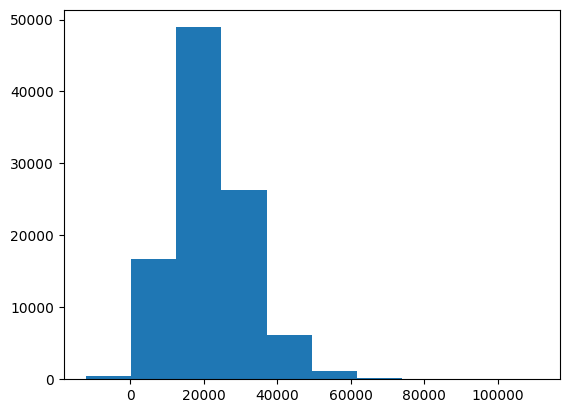

In [44]:
print(f"Mean Profit for Wet Well: {np.mean(sims)}")
plt.hist(sims / 1000)
plt.show()


In [45]:
sims.min()

np.float64(-12034479.35822374)

### Losses for Dry Wells

In [13]:
def dry(n = 10):
    salaries = pd.Series(np.random.triangular(left = 172000,mode = 215000, right = 279500,size = n))
    initials = pd.Series(initial(n = n,dry = True))
    loss = salaries + initials
    loss = loss * -1
    return(loss)
    

In [14]:
a = dry(100000)

Mean Loss for Dry: -5795955.552044979


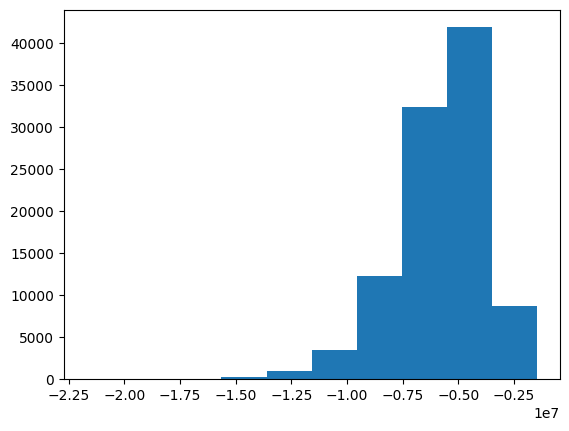

In [15]:
print(f"Mean Loss for Dry: {a.mean()}")
plt.hist(a)
plt.show()
